In [1]:
# !pip install zipline

In [3]:
import pandas as pd
from plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
import pyfolio
from pyfolio import timeseries
# import warnings
# warnings.filterwarnings('ignore')

test_return_raw = pd.read_csv('./train_history_DDPG_2022/cumulative_return/cumu_return2022-10-25 171720.csv')
# test_return_raw = pd.read_csv('try.csv')
#diff()/pct
test_return_raw.columns=['step','return']

test_return = (test_return_raw.pct_change())

print(len(test_return))
DRL_strat = convert_daily_return_to_pyfolio_ts(test_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")

perf_stats_all

C:\Users\Mickey\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


191
==============DRL Strategy Stats===========


Annual return         -0.173135
Cumulative returns    -0.134194
Annual volatility      0.150168
Sharpe ratio          -1.197270
Calmar ratio          -1.182725
Stability              0.289381
Max drawdown          -0.146386
Omega ratio            0.827526
Sortino ratio         -1.565470
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.898815
Daily value at risk   -0.019633
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [5]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
#         ticker="%5EGSPC",
        ticker="%5EGSPC",
        start='2022-01-01',
        end='2022-10-25')

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (204, 9)
Annual return         -0.250660
Cumulative returns    -0.208320
Annual volatility      0.244177
Sharpe ratio          -1.065068
Calmar ratio          -0.985876
Stability              0.672679
Max drawdown          -0.254251
Omega ratio            0.843968
Sortino ratio         -1.418666
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.878563
Daily value at risk   -0.031795
dtype: float64


In [6]:
## import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker="%5EGSPC,", 
        start='2022-01-01',
        end='2022-10-25')

baseline_returns = get_daily_return(baseline_df, value_col_name="close")
DRL_strat.index = baseline_returns.index[len(baseline_returns)-len(DRL_strat):]



with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (204, 9)


Start date,2022-01-21
End date,2022-10-24
Total months,9
,Backtest
Annual return,-17.3%
Cumulative returns,-13.4%
Annual volatility,15.0%
Sharpe ratio,-1.20
Calmar ratio,-1.18
Stability,0.29
Max drawdown,-14.6%


IndexError: index -1 is out of bounds for axis 0 with size 0

## action

In [38]:
import pandas as pd
df = pd.read_csv('./test_history/action/action2022-05-13 11_02_30.csv')
df.iloc[:,1]

0      0.019868
1      0.026559
2      0.020738
3      0.032077
4      0.022754
         ...   
222    0.026623
223    0.026617
224    0.022756
225    0.032085
226    0.026638
Name: 0, Length: 227, dtype: float64

In [39]:
buy_sig = df['0'].diff()>0.1
sell_sig = df['0'].diff()<-0.1

In [40]:
from Data_processor import YahooFinanceProcessor
import numpy as np
# 資料下載與前處理(只包含training範圍的資料)

# 設定資料日期範圍
TRAIN_START_DATE = "2017-01-01"
TRAIN_END_DATE = "2020-01-01"

TEST_START_DATE = "2021-01-01"
TEST_END_DATE = "2022-01-01"


# 股票代碼與技術指標的list
ticker_list = ['ge', 'f', 'aapl', 'aal', 'bac', 'ccl', 'amd', 'wfc', 't', 'msft', 'pfe']
tech_list = []

# 技術指標與VIX的開關，如果不想加就設定為False
if_vix = True
if_tech = False

# 下載並清洗資料
DP = YahooFinanceProcessor()
train_data = DP.download_data(start_date = TRAIN_START_DATE,end_date = TRAIN_END_DATE,ticker_list = ticker_list, time_interval='1D')
train_data = DP.clean_data(train_data)
test_data = DP.download_data(start_date = TEST_START_DATE,end_date = TEST_END_DATE,ticker_list = ticker_list, time_interval='1D')
test_data = DP.clean_data(test_data)

# 加入技術指標和恐慌指數(如果有的話)
if if_tech:
    tech_list = ['close_30_sma','close_60_sma','macd','boll_ub','boll_lb','dx_30','rsi_30']
    train_data = DP.add_technical_indicator(train_data, tech_list)
    test_data = DP.add_technical_indicator(test_data, tech_list)
if if_vix:
    train_data = DP.add_vix(train_data)
    test_data = DP.add_vix(test_data)
    
# DataFrame轉成np.array
price_array_train, tech_array_train, turbulence_array_train = DP.df_to_array(train_data,tech_list, if_vix, if_tech)
price_array_test, tech_array_test, turbulence_array_test = DP.df_to_array(test_data,tech_list, if_vix, if_tech)

# 加入額外的state資訊 ( RN embedding )
aug_state_array_train = np.zeros((0,0))
aug_state_array_test = np.zeros((0,0))
# aug_state_array_train = np.load('./RN/GE_rn_rt6rn_train.npy')
# aug_state_array_test = np.load('./RN/GE_rn_rt6rn_test.npy')

# aug_state_array = np.zeros((price_array.shape[0],11,8)) # (754,11,8)


# 印一下形狀
print('=============')
print('price_array_train: ',price_array_train.shape)
# price_array_train = price_array_train[len(price_array_train)-len(aug_state_array_train):]
# print('price_array_train: ',price_array_train.shape)

print('tech_array_train: ',tech_array_train.shape)
# tech_array_train = tech_array_train[len(tech_array_train)-len(aug_state_array_train):]
# print('tech_array_train: ',tech_array_train.shape)


print('turbulence_array_train: ',turbulence_array_train.shape)
# turbulence_array_train = turbulence_array_train[len(turbulence_array_train)-len(aug_state_array_train):]
# print('turbulence_array_train: ',turbulence_array_train.shape)

print('aug_state_array_train: ',aug_state_array_train.shape)
# aug_state_array_train = np.reshape(aug_state_array_train,(-1,8*11))
# print('aug_state_array_train: ',aug_state_array_train.shape)

print('-----------')
print('price_array_test: ',price_array_test.shape)
# price_array_test = price_array_test[len(price_array_test)-len(aug_state_array_test):]
# print('price_array_test: ',price_array_test.shape)


print('tech_array_test: ',tech_array_test.shape)
# tech_array_test = tech_array_test[len(tech_array_test)-len(aug_state_array_test):]
# print('tech_array_test: ',tech_array_test.shape)


print('turbulence_array_test: ',turbulence_array_test.shape)
# turbulence_array_test = turbulence_array_test[len(turbulence_array_test)-len(aug_state_array_test):]
# print('turbulence_array_test: ',turbulence_array_test.shape)


print('aug_state_array_test: ',aug_state_array_test.shape)
# aug_state_array_test = np.reshape(aug_state_array_test,(-1,8*11))
# print('aug_state_array_test: ',aug_state_array_test.shape)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (8294, 9)
Clean data for aal
Data clean for aal is finished.
Clean data for aapl
Data clean for aapl is finished.
Clean data for amd
Data clean for amd is finished.
Clean data for bac
Data clean for bac is finished.
Clea

In [43]:
price_array_test.shape[0]-10-1-14

227

In [44]:
len(df['0'].diff().fillna(0))
Y = price_array_test[25:,0]
len(Y)

227

KeyError: 227

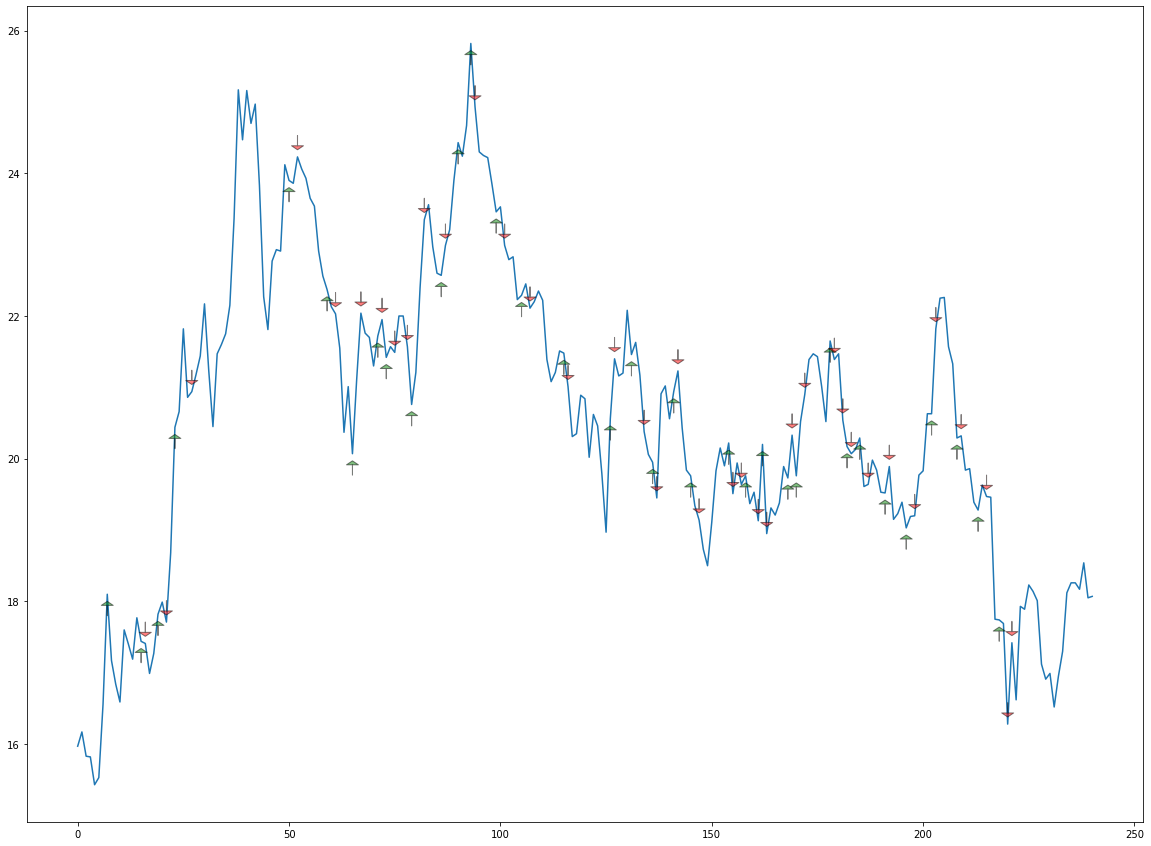

In [45]:
# fig,ax = plt.subplot(price_array[:,0],figsize = (10,10))
# #plt.plot(df['0']*150)
import matplotlib.pyplot as plt

%matplotlib inline
for num,name in enumerate(ticker_list):
    
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(20)
    ax = fig.add_subplot(111)
    Y = price_array_test[11:,num]
    X = range(len(Y))
    buy_sig = df.iloc[:,num+1].diff().fillna(0)>0.1
    sell_sig = df.iloc[:,num+1].diff().fillna(0)<-0.1
    ax.plot(X,Y)
    for i in X:
        if buy_sig[i]:
            #print('buy')
            ax.annotate("", xy=(i, Y[i]-0.1),xytext=(i, Y[i]-0.3), arrowprops=dict(facecolor="g", alpha=0.5, headlength=4, width=0.1)) 
        elif sell_sig[i]:
            #print('sell')
            ax.annotate("", xy=(i, Y[i]+0.1),xytext=(i, Y[i]+0.3),arrowprops=dict(facecolor="r", alpha=0.5, headlength=4, width=0.1)) 
    plt.title(name)
    plt.show()
